In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from IPython import display
plt.style.use('seaborn')
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn import linear_model

# Exploring the BNP transect data: visible wavelengths, restricted range

In this notebook I am exploring the BNP transect data from 5/27 and 6/4 using just the wavelengths from 533 to 847 nm.  The visible spectrometer data from these wavelengths appears to be fairly stable.

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp

def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp

def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal

def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal

def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves

def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves

def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs

def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw

def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_ftir_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer2/spectrum_depths'][:]
        return depths

def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps

def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs

def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def get_visible_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer1/spectrum_depths'][:]
        return depths   

def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]
        return insertions

def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions

def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp

def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp

def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal

def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal

def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

def normalize_depth(depth, depth_min, depth_max):
    return (depth - depth_min) / (depth_max - depth_min)

def get_spectrometer_name(file, session, spectrometer_number):
    with h5py.File(file, 'r') as h5_file:
        name = h5_file[session].attrs[f'spectrometer{spectrometer_number}'][:]
        return name

# Get and clean the dataset

In [3]:
# read the total list of data files
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
green_list_df = pd.read_csv('data/Green_misc_insertions_210604.csv')

# establish the file name for the first date
date='5/27/21'
bath_df = green_list_df.loc[green_list_df['date'] == date]
file_name = bath_df.iat[0, 0]
file = path_name + file_name

# since the wavelength vector does not change from session to session, here I get the first one.
calibration = bath_df['calibration'][120]
session = bath_df['session'][120]
cal_path = f'{session}/{calibration}'
vis_waves = get_visible_wavelength_vector(file, cal_path)

# this produces a list of strings of wavelength values
vis_columns = ["%.1f" % wave for wave in vis_waves]

# these are used to establish the first and last wavelengths that will be used in the analysis
vis_min_index = vis_columns.index('533.4')
vis_max_index = vis_columns.index('847.1')

vis_length = vis_max_index - vis_min_index

# here the actual data are read and compiled into a dataframe
all_absorbances = []
all_depths = []
df = pd.DataFrame()

dates = ['5/27/21', '6/4/21']

for date in dates: 
    bath_df = green_list_df.loc[green_list_df['date'] == date]
    file_name = bath_df.iat[0, 0]
    file = path_name + file_name
    
    for index in bath_df.index.values:
        session = bath_df['session'][index]
        calibration = bath_df['calibration'][index]
        insertion = bath_df['insertion'][index]
        i_unique = bath_df['i_unique'][index]
        stop = date + " " + bath_df['target'][index][-3:]
        cal_path = f'{session}/{calibration}'
        insertion_path = f'{session}/{calibration}/{insertion}'
        vis_waves = get_visible_wavelength_vector(file, cal_path)[vis_min_index:vis_max_index]
        vis_columns = ["%.1f" % wave for wave in vis_waves]
        insertion_df = pd.DataFrame(get_visible_insertion_absorbances(file, insertion_path)[:, vis_min_index:vis_max_index], columns=vis_columns)
        insertion_df['depth'] = get_visible_insertion_spectrum_depths(file, insertion_path)
        insertion_df['session'] = session
        insertion_df['calibration'] = calibration
        insertion_df['insertion'] = insertion
        insertion_df['i_unique'] = i_unique
        insertion_df['stop'] = stop
        insertion_df['use'] = True
        df = pd.concat([df, insertion_df], ignore_index=True)

# this will be used to eliminate spectra that are invalid because they are from above the surface
df.loc[(df.depth < 5.0),'use'] = False

# this will be used to eliminate vegetation spectra
df.loc[(df['671.2']/df['735.7'] > 1.3), 'use'] = False

    
print(df.shape)

(1125, 248)


In [4]:
# these will be used as a surrogate for higher and lower SOC values.
# higher class numbers would be expected in general to have higher SOC content.

df['class'] = 1
df.loc[df['depth'] < 25, 'class'] = 2
df.loc[df['stop'] == '6/4/21 #10', 'class'] = 4
df.loc[df['stop'] == '6/4/21  #9', 'class'] = 4
df.loc[df['stop'] == '6/4/21  #8', 'class'] = 3
df.loc[df['stop'] == '5/27/21  #6', 'class'] = 3

In [5]:
# creates a dataframe containing only the "use" rows
df_use = df.loc[df['use']].copy()
print(df_use.shape)

(1006, 249)


# Plot the spectra

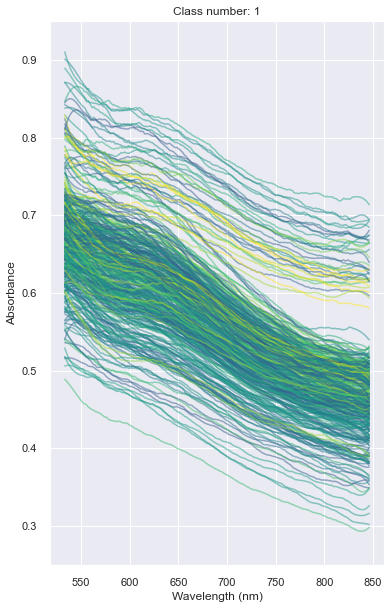

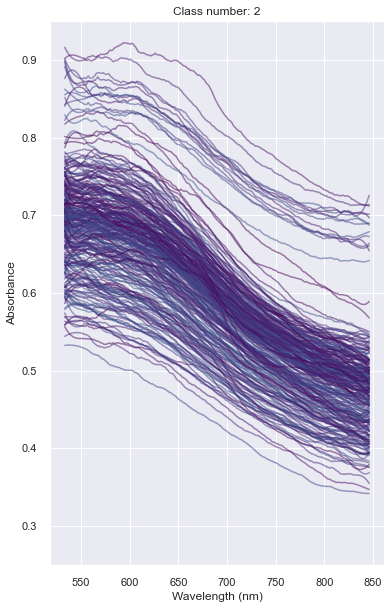

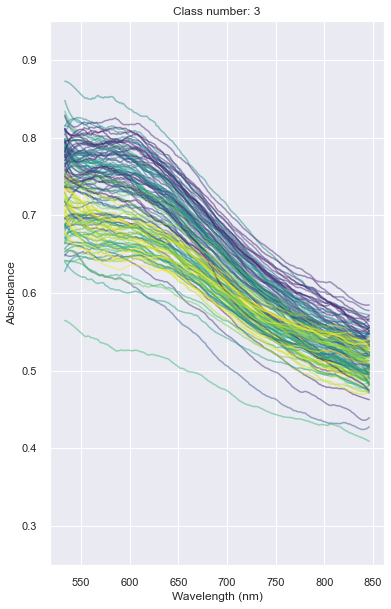

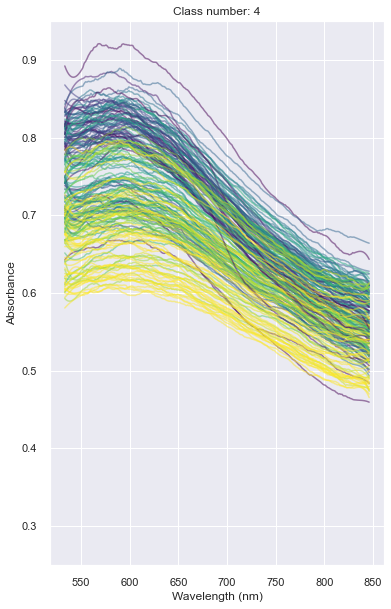

In [6]:
# plot the spectra by class number

depth_min = 5.0
depth_max = 75.0

for class_number in [1, 2, 3, 4]:
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.set_title(f'Class number: {class_number}')
    ax.set_ylim(0.25, 0.95)
    ax.set_ylabel('Absorbance')
    ax.set_xlabel('Wavelength (nm)')
    df_class = df_use.loc[df_use['class'] == class_number]
    for index in df_class.index:
        depth = df_class['depth'][index]
        color = plt.cm.viridis(normalize_depth(depth, depth_min, depth_max ))
        ax.plot(vis_waves, savgol_filter(df_class.loc[index, vis_columns], 27, 3), color=color, alpha=0.5)
plt.show()
plt.close()

In the next few cells, I am trying to see if there would be an advantage to taking the mean values for five columns at a time (in effect, degrading the wavelength resolution of the dataset).

In [7]:
row = df_use.loc[index, vis_columns]
for column_group in range(0, len(vis_columns)-1, 5):

    print(vis_columns[column_group], vis_columns[column_group + 1], vis_columns[column_group + 2], vis_columns[column_group + 3], vis_columns[column_group + 4])
    print(row[vis_columns[column_group]:vis_columns[column_group + 4]].mean())

533.4 534.8 536.2 537.7 539.1
0.6466008546235001
540.5 541.9 543.4 544.8 546.2
0.6458740442086267
547.6 549.0 550.5 551.9 553.3
0.6512972132217683
554.7 556.1 557.5 558.9 560.3
0.658084013072229
561.7 563.1 564.5 565.9 567.3
0.6528987040115231
568.7 570.1 571.5 572.9 574.3
0.656539745072492
575.7 577.0 578.4 579.8 581.2
0.6624470302959785
582.6 584.0 585.3 586.7 588.1
0.6649523515566294
589.5 590.8 592.2 593.6 594.9
0.6606844348115802
596.3 597.7 599.0 600.4 601.8
0.665071106733613
603.1 604.5 605.8 607.2 608.6
0.6662532018060243
609.9 611.3 612.6 614.0 615.3
0.6574859315962758
616.7 618.0 619.4 620.7 622.1
0.6500787598077185
623.4 624.7 626.1 627.4 628.8
0.6607606276173726
630.1 631.5 632.8 634.1 635.5
0.6571978802138299
636.8 638.1 639.5 640.8 642.1
0.6464960141263972
643.5 644.8 646.1 647.4 648.8
0.6459808673568957
650.1 651.4 652.7 654.1 655.4
0.6424189171524268
656.7 658.0 659.3 660.7 662.0
0.6379187347025409
663.3 664.6 665.9 667.2 668.5
0.6318151883554864
669.9 671.2 672.5 673.8

In [8]:
vis_columns_centers = []
for i in range(0, len(vis_columns)-1, 5):
    vis_columns_centers.append(vis_columns[i + 2])
print(vis_columns_centers)
print(len(vis_columns_centers))

['536.2', '543.4', '550.5', '557.5', '564.5', '571.5', '578.4', '585.3', '592.2', '599.0', '605.8', '612.6', '619.4', '626.1', '632.8', '639.5', '646.1', '652.7', '659.3', '665.9', '672.5', '679.0', '685.5', '692.0', '698.5', '705.0', '711.4', '717.8', '724.2', '730.6', '737.0', '743.3', '749.7', '756.0', '762.3', '768.6', '774.8', '781.0', '787.3', '793.5', '799.6', '805.8', '811.9', '818.0', '824.1', '830.2', '836.2', '842.3']
48


In [9]:
print(row)

533.4     0.64404
534.8    0.641695
536.2    0.650811
537.7    0.650198
539.1     0.64626
           ...   
841.1    0.527299
842.3    0.539726
843.5    0.535677
844.7    0.536862
845.9    0.547318
Name: 1078, Length: 241, dtype: object


In [10]:
centered_row = []
for i in range(2, len(vis_columns)-1, 5):
    column_value = row[i-2:i+2].mean()
    centered_row.append(column_value)
print(len(centered_row))

48


### Plots to examine effect of taking average for five columns at a time

In the next couple cells I plot a single row using four styles:  raw data, averaged data, and two levels of savgol_filter smoothing.

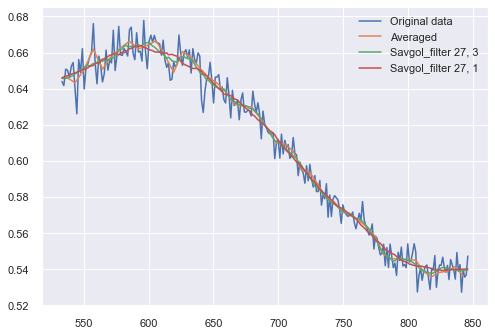

In [11]:
wavelengths = [float(wave) for wave in vis_columns_centers]
plt.plot(vis_waves, row, label="Original data")
plt.plot(wavelengths, centered_row, label="Averaged")
plt.plot(vis_waves, savgol_filter(row, 27, 3), label="Savgol_filter 27, 3")
plt.plot(vis_waves, savgol_filter(row, 27, 1), label="Savgol_filter 27, 1")
plt.legend()
plt.show()
plt.close()

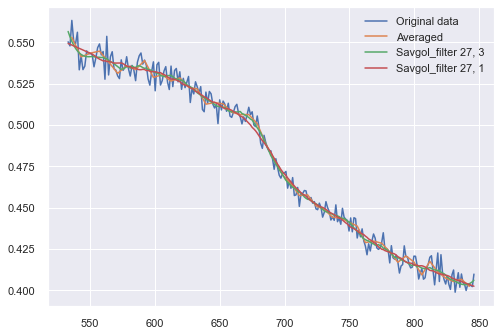

In [12]:
row = df_use.loc[2, vis_columns]
vis_columns_centers = []
for i in range(0, len(vis_columns)-1, 5):
    vis_columns_centers.append(vis_columns[i + 2])
centered_row = []
for i in range(2, len(vis_columns)-1, 5):
    column_value = row[i-2:i+2].mean()
    centered_row.append(column_value)    
wavelengths = [float(wave) for wave in vis_columns_centers]
plt.plot(vis_waves, row, label="Original data")
plt.plot(wavelengths, centered_row, label="Averaged")
plt.plot(vis_waves, savgol_filter(row, 27, 3), label="Savgol_filter 27, 3")
plt.plot(vis_waves, savgol_filter(row, 27, 1), label="Savgol_filter 27, 1")
plt.legend()
plt.show()
plt.close()

# Exploring first derivative spectra

In the next couple of plots, I explor taking first derivative spectra.

The jagged spectra are the first derivatives of the original spectra.
The smoothed spectra are first derivatives of smoothed spectra.

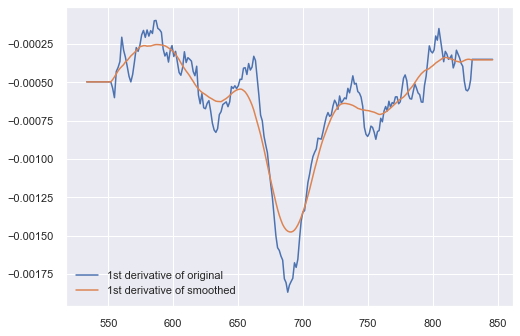

In [13]:
row = df_use.loc[2, vis_columns]
sg_row = savgol_filter(row, 27, 1)
plt.plot(vis_waves, savgol_filter(row, 27, 1, deriv=1), label="1st derivative of original")
plt.plot(vis_waves, savgol_filter(sg_row, 27, 1, deriv=1), label="1st derivative of smoothed")
plt.legend()
plt.show()
plt.close()

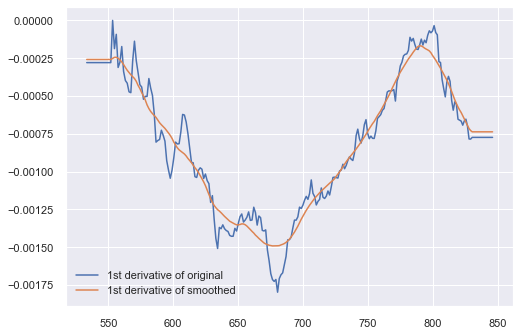

In [14]:
row = df_use.loc[1124, vis_columns]
sg_row = savgol_filter(row, 27, 1)
plt.plot(vis_waves, savgol_filter(row, 27, 1, deriv=1), label="1st derivative of original")
plt.plot(vis_waves, savgol_filter(sg_row, 27, 1, deriv=1), label="1st derivative of smoothed")
plt.legend()
plt.show()
plt.close()

In [15]:
stops = df_use['stop'].unique()
stops

array(['5/27/21  #1', '5/27/21  #2', '5/27/21  #3', '5/27/21  #4',
       '5/27/21  #5', '5/27/21  #6', '6/4/21  #1', '6/4/21  #2',
       '6/4/21  #3', '6/4/21  #4', '6/4/21  #5', '6/4/21  #6',
       '6/4/21  #7', '6/4/21  #8', '6/4/21  #9', '6/4/21 #10'],
      dtype=object)

### Compare smoothed spectra to first derivative spectra for 6/4/21 #1 (top of hill)

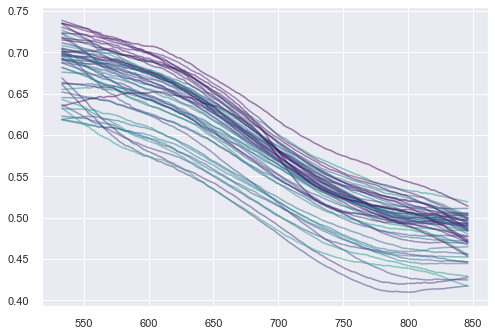

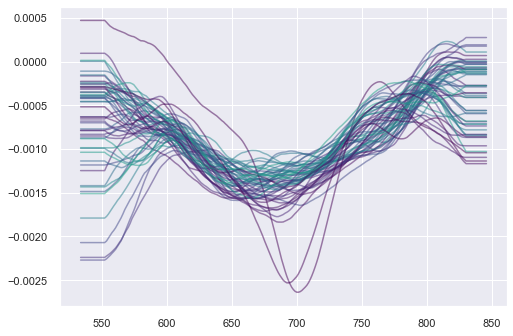

In [16]:
top_of_hill = df_use.loc[df_use['stop'] == stops[6]]

fig, ax = plt.subplots()
for index in top_of_hill.index.values:
    row = top_of_hill.loc[index, vis_columns]
    sg_row = savgol_filter(row, 27, 1)
    depth = top_of_hill['depth'][index]
    color = plt.cm.viridis(normalize_depth(depth, depth_min, depth_max ))
    ax.plot(vis_waves, sg_row, color=color, alpha=0.5)
plt.show()
plt.close()

fig, ax = plt.subplots()
for index in top_of_hill.index.values:
    row = top_of_hill.loc[index, vis_columns]
    sg_row = savgol_filter(row, 27, 1)
    depth = top_of_hill['depth'][index]
    color = plt.cm.viridis(normalize_depth(depth, depth_min, depth_max ))
    ax.plot(vis_waves, savgol_filter(sg_row, 27, 1, deriv=1), color=color, alpha=0.5)
plt.show()
plt.close()
    

### Compare smoothed spectra to first derivative spectra for 6/4/21 #10 (bottom of hill)

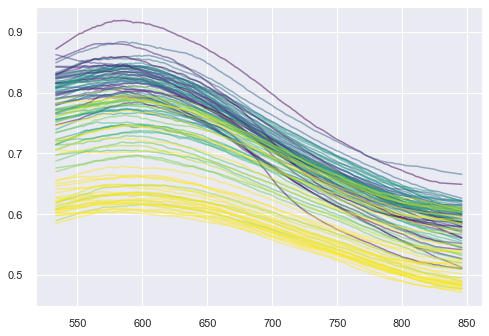

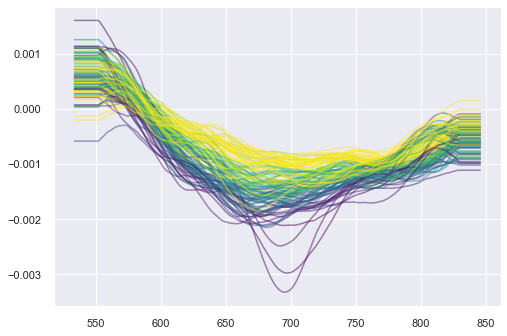

In [17]:
bottom_of_hill = df_use.loc[df_use['stop'] == stops[15]]

fig, ax = plt.subplots()
for index in bottom_of_hill.index.values:
    row = bottom_of_hill.loc[index, vis_columns]
    sg_row = savgol_filter(row, 27, 1)
    depth = bottom_of_hill['depth'][index]
    color = plt.cm.viridis(normalize_depth(depth, depth_min, depth_max ))
    ax.plot(vis_waves, sg_row, color=color, alpha=0.5)
plt.show()
plt.close()

fig, ax = plt.subplots()
for index in bottom_of_hill.index.values:
    row = bottom_of_hill.loc[index, vis_columns]
    sg_row = savgol_filter(row, 27, 1)
    depth = bottom_of_hill['depth'][index]
    color = plt.cm.viridis(normalize_depth(depth, depth_min, depth_max ))
    ax.plot(vis_waves, savgol_filter(sg_row, 27, 1, deriv=1), color=color, alpha=0.5)
plt.show()
plt.close()

## Plots of all the first derivative spectra, grouped by class number

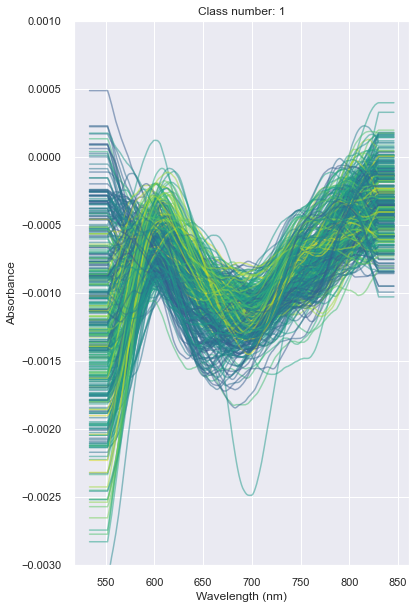

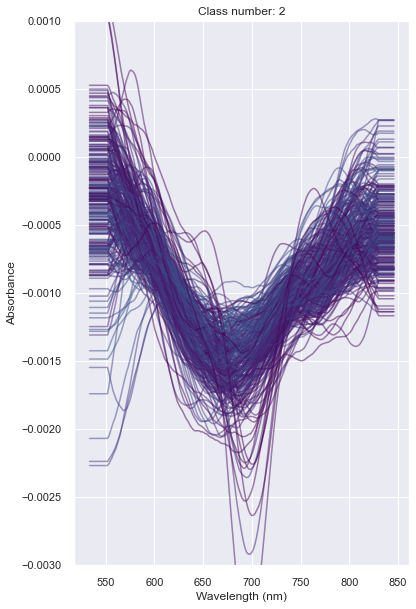

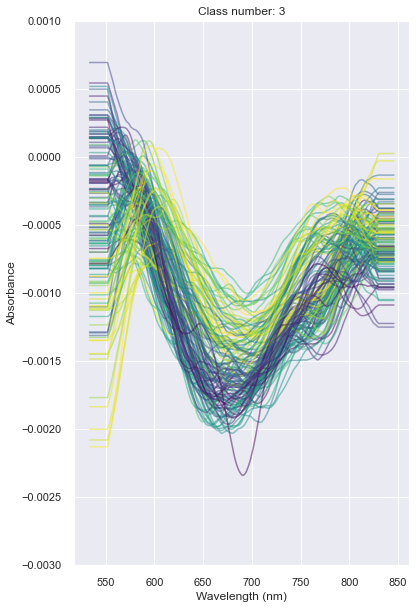

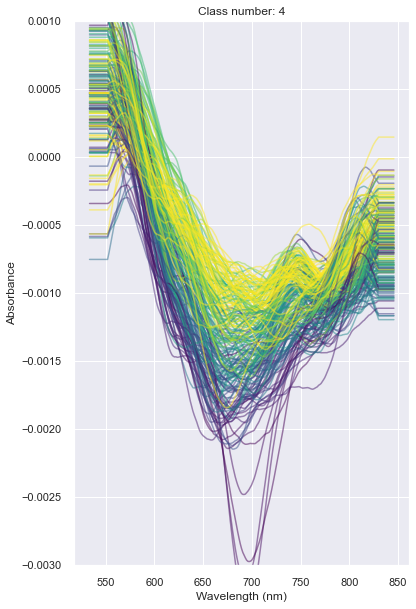

In [18]:
# plot the spectra by class number

depth_min = 5.0
depth_max = 75.0

for class_number in [1, 2, 3, 4]:
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.set_title(f'Class number: {class_number}')
    ax.set_ylim(-0.003, 0.001)
    ax.set_ylabel('Absorbance')
    ax.set_xlabel('Wavelength (nm)')
    df_class = df_use.loc[df_use['class'] == class_number]
    for index in df_class.index:
        row = df_class.loc[index, vis_columns]
        sg_row = savgol_filter(row, 27, 1)
        depth = df_class['depth'][index]
        color = plt.cm.viridis(normalize_depth(depth, depth_min, depth_max ))
        ax.plot(vis_waves, savgol_filter(sg_row, 27, 1, deriv=1), color=color, alpha=0.5)
plt.show()
plt.close()

# PCA using original data

In [19]:
X = df_use.iloc[:, :-8].copy()
X.shape

(1006, 241)

In [20]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

In [21]:
pc_labels = []
for i in range(10):
    
    pc_label = f"PC{i + 1}"
    pc_labels.append(pc_label)
print(pc_labels)



['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']


In [22]:
np.cumsum(pca.explained_variance_ratio_)

array([0.95419543, 0.98309974, 0.98890733, 0.98998063, 0.99046439,
       0.99083183, 0.9910655 , 0.99128158, 0.99147589, 0.99165798])

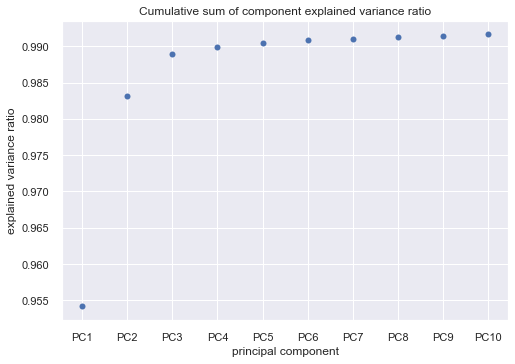

In [23]:
fig, ax = plt.subplots()
ax.set_title('Cumulative sum of component explained variance ratio')
ax.set_xlabel("principal component")
ax.set_ylabel("explained variance ratio")

ax.plot(pc_labels, np.cumsum(pca.explained_variance_ratio_), 'bo')
plt.show()
plt.close()

In [24]:
X_pca_df = pd.DataFrame(X_pca, columns=pc_labels)

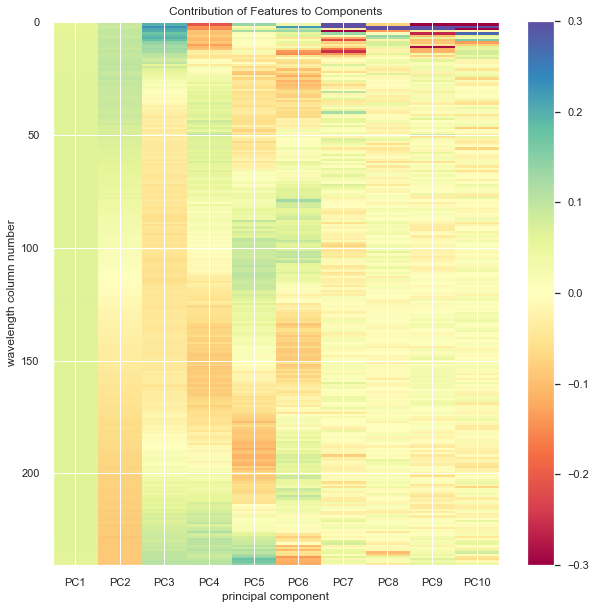

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
data = pca.components_[:10].T
plt.imshow(data, cmap="Spectral", vmin=-0.3, vmax=0.3, aspect='auto',
          interpolation='none')
ax.set_xticks(np.arange(data.shape[1]))
ax.set_xticklabels(pc_labels)
# plt.yticks(range(len(X.columns)), X.columns)
plt.title("Contribution of Features to Components")
plt.xlabel("principal component")
plt.ylabel("wavelength column number")
plt.colorbar()
plt.show()
plt.close()

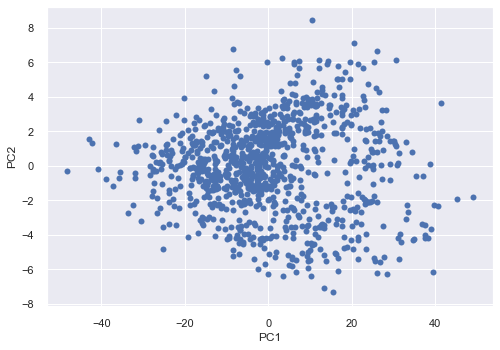

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.plot(X_pca_df['PC1'], X_pca_df['PC2'], 'o')
plt.show()
plt.close()

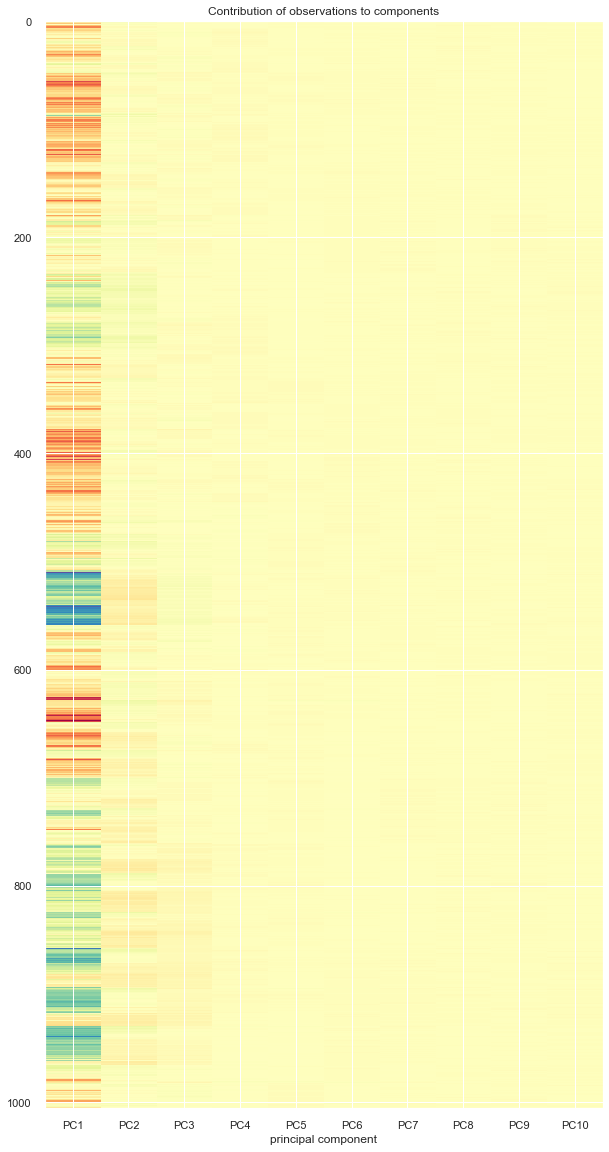

In [27]:
fig, ax = plt.subplots(figsize=(10, 20))
ax.set_xticks(np.arange(data.shape[1]))
ax.set_xticklabels(pc_labels)
ax.set_title("Contribution of observations to components")
plt.imshow(X_pca[:, :10], cmap="Spectral", aspect='auto',
          interpolation='none')
# plt.yticks(range(len(X.columns)), X.columns)
plt.xlabel("principal component")
plt.show()
plt.close()

In [28]:
df_info = df_use.iloc[:, -8:].copy().reset_index()

In [29]:
X_pca_df.index

RangeIndex(start=0, stop=1006, step=1)

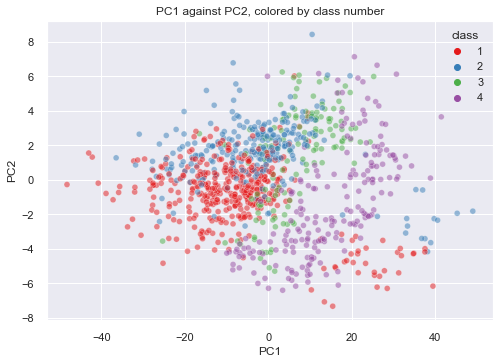

In [30]:
fig, ax = plt.subplots()
ax.set_title("PC1 against PC2, colored by class number")
sns.scatterplot(x=X_pca_df['PC1'], y=X_pca_df['PC2'], 
                hue=df_info['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

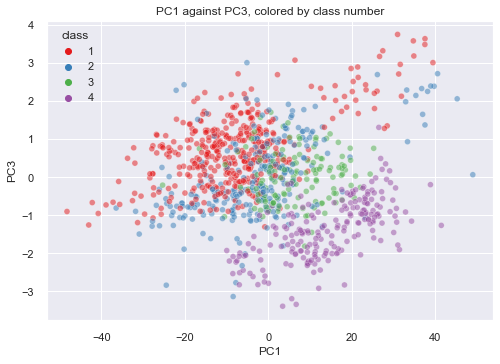

In [31]:
fig, ax = plt.subplots()
ax.set_title("PC1 against PC3, colored by class number")
sns.scatterplot(x=X_pca_df['PC1'], y=X_pca_df['PC3'], 
                hue=df_info['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

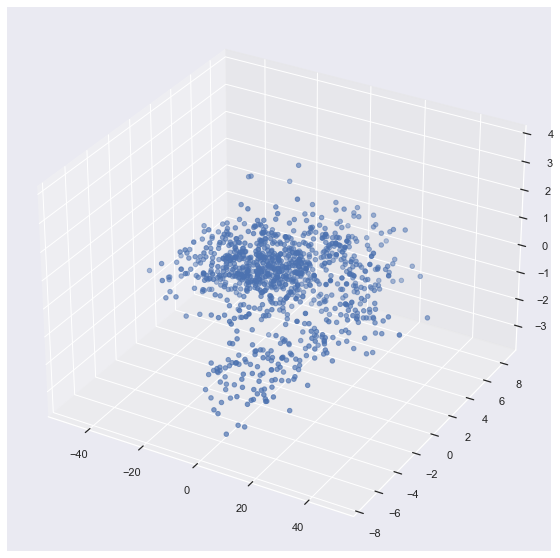

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d' )
ax.scatter(X_pca_df['PC1'], X_pca_df['PC2'], X_pca_df['PC3'])
plt.show()
plt.close()

This is code for an interactive plot in 3d.

%matplotlib qt

ax = plt.axes(projection='3d')
class_1 = X_pca_df.loc[df_info['class'] == 1]
xdata = class_1['PC1']
ydata = class_1['PC2']
zdata = class_1['PC3']
ax.scatter3D(xdata, ydata, zdata, color = 'b')

class_2 = X_pca_df.loc[df_info['class'] == 2]
xdata2 = class_2['PC1']
ydata2 = class_2['PC2']
zdata2 = class_2['PC3']
ax.scatter3D(xdata2, ydata2, zdata2, color = 'c')

class_3 = X_pca_df.loc[df_info['class'] == 3]
xdata3 = class_3['PC1']
ydata3 = class_3['PC2']
zdata3 = class_3['PC3']
ax.scatter3D(xdata3, ydata3, zdata3, color = 'g')

class_4 = X_pca_df.loc[df_info['class'] == 4]
xdata4 = class_4['PC1']
ydata4 = class_4['PC2']
zdata4 = class_4['PC3']
ax.scatter3D(xdata4, ydata4, zdata4, color = 'r')

<AxesSubplot:xlabel='stop', ylabel='PC1'>

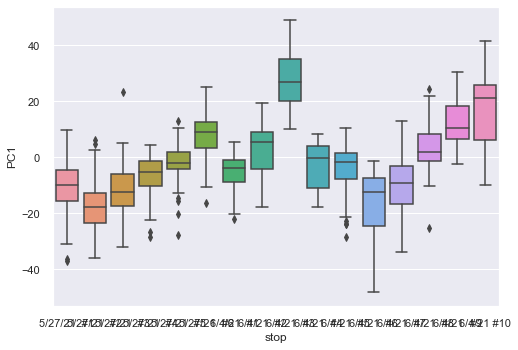

In [33]:
sns.boxplot(x=df_info['stop'], y=X_pca_df['PC1'])

<AxesSubplot:xlabel='stop', ylabel='PC2'>

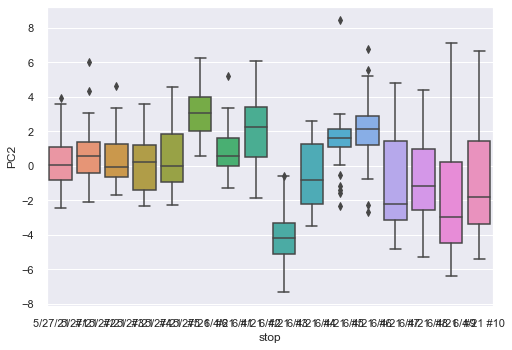

In [34]:
sns.boxplot(x=df_info['stop'], y=X_pca_df['PC2'])

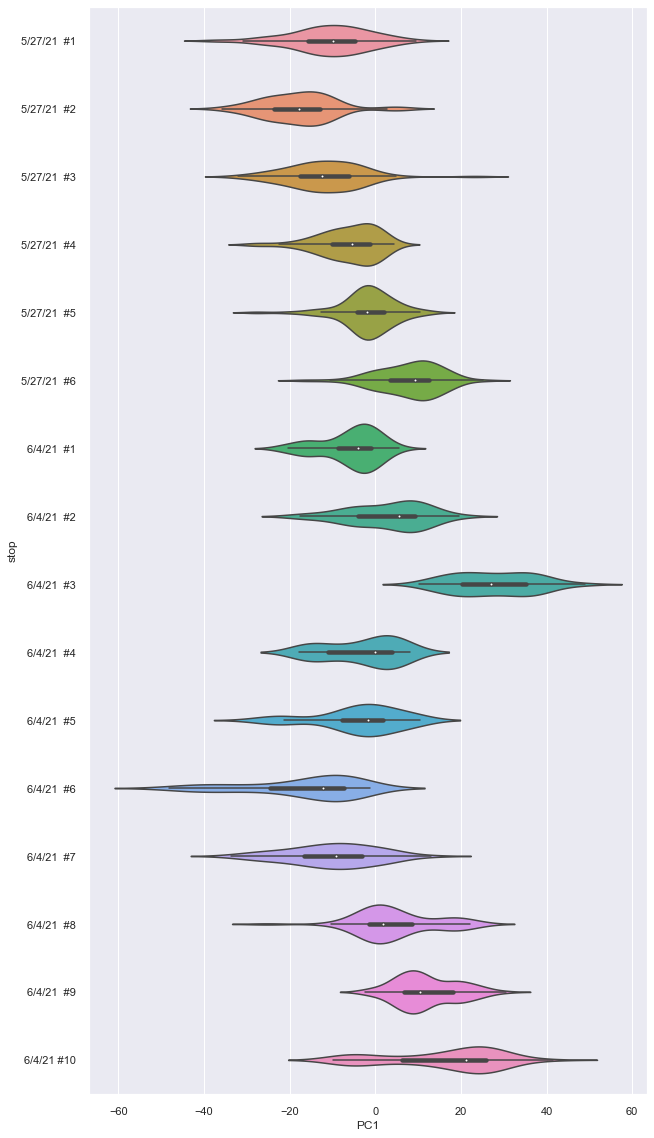

In [35]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.violinplot(y=df_info['stop'], x=X_pca_df['PC1'])
plt.show()
plt.close()

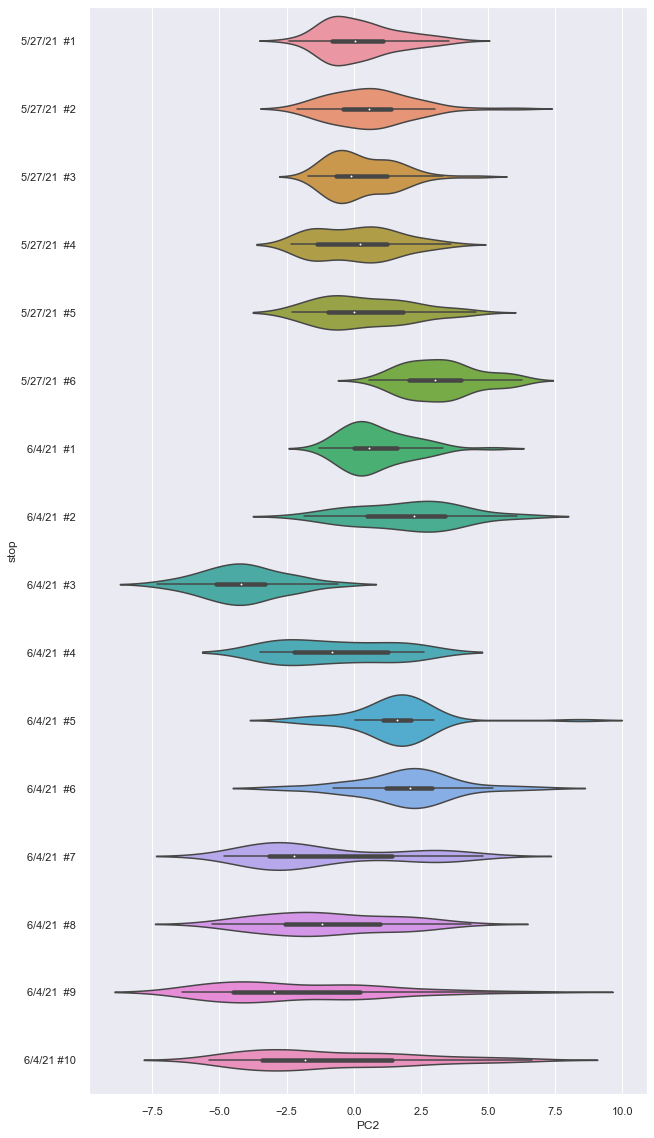

In [36]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.violinplot(y=df_info['stop'], x=X_pca_df['PC2'])
plt.show()
plt.close()

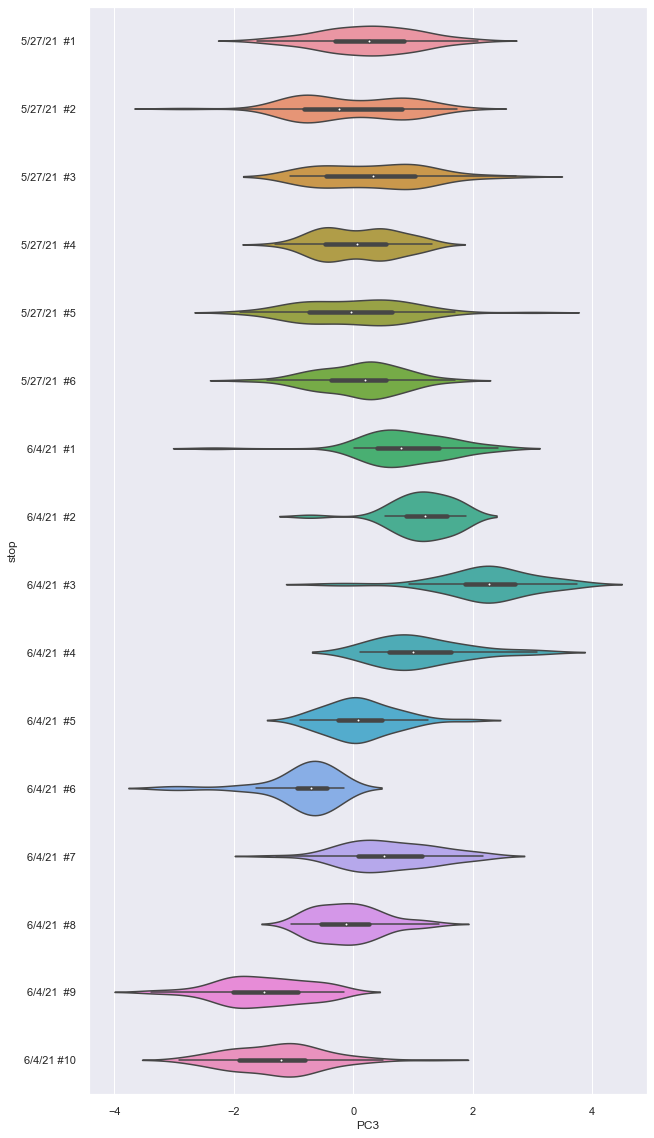

In [37]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.violinplot(y=df_info['stop'], x=X_pca_df['PC3'])
plt.show()
plt.close()

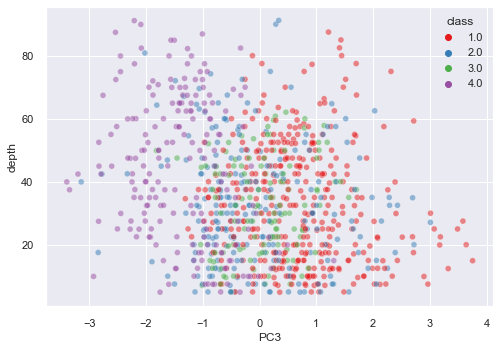

In [38]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_pca_df['PC3'], y=df_use['depth'], 
                hue=df_info['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

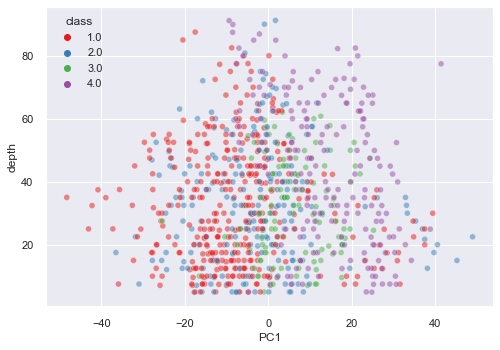

In [39]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_pca_df['PC1'], y=df_use['depth'], 
                hue=df_info['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

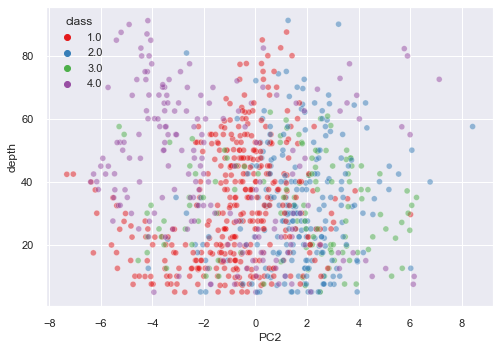

In [40]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_pca_df['PC2'], y=df_use['depth'], 
                hue=df_info['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

## Explore the distribution of PC3

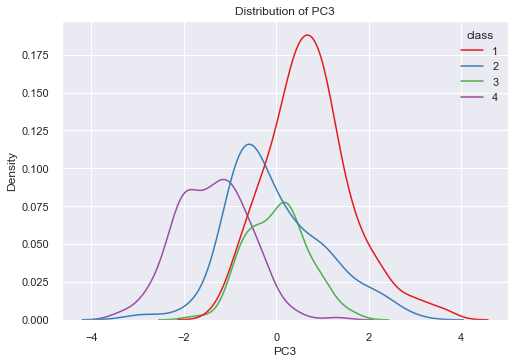

In [41]:
fig, ax = plt.subplots()
ax.set_title("Distribution of PC3")
sns.kdeplot(x=X_pca_df['PC3'], hue=df_info['class'], palette='Set1')
plt.show()
plt.close()

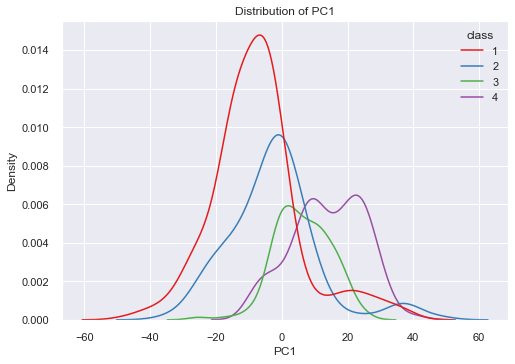

In [54]:
fig, ax = plt.subplots()
ax.set_title("Distribution of PC1")
sns.kdeplot(x=X_pca_df['PC1'], hue=df_info['class'], palette='Set1')
plt.show()
plt.close()

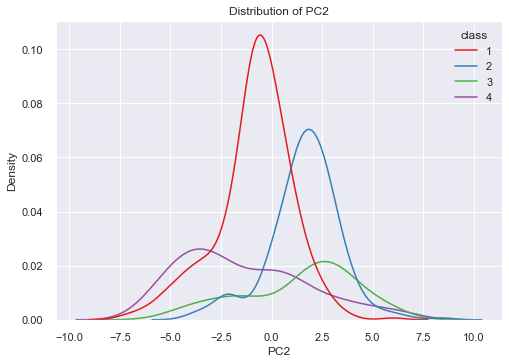

In [55]:
fig, ax = plt.subplots()
ax.set_title("Distribution of PC2")
sns.kdeplot(x=X_pca_df['PC2'], hue=df_info['class'], palette='Set1')
plt.show()
plt.close()

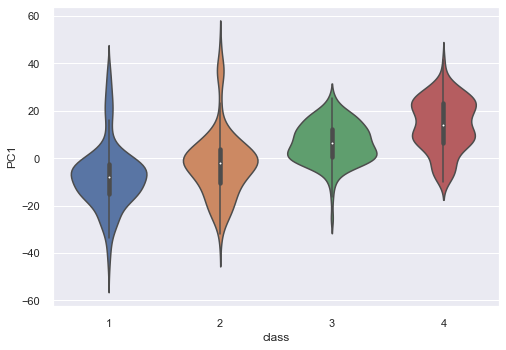

In [42]:
fig, ax = plt.subplots()
sns.violinplot(x=df_info['class'], y=X_pca_df['PC1'])
plt.show()
plt.close()

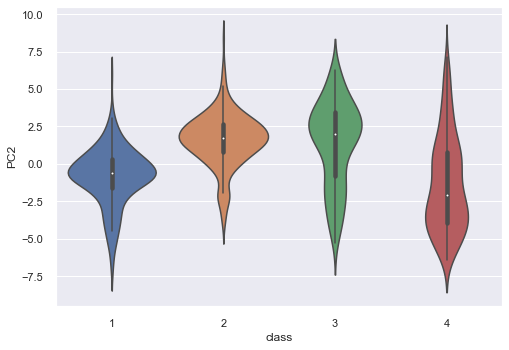

In [43]:
fig, ax = plt.subplots()
sns.violinplot(x=df_info['class'], y=X_pca_df['PC2'])
plt.show()
plt.close()

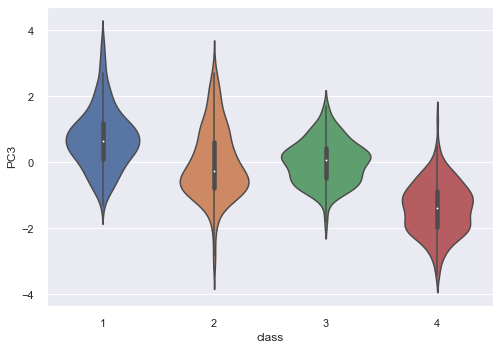

In [44]:
fig, ax = plt.subplots()
sns.violinplot(x=df_info['class'], y=X_pca_df['PC3'])
plt.show()
plt.close()

### Plot PC3 by depth for each insertion separately

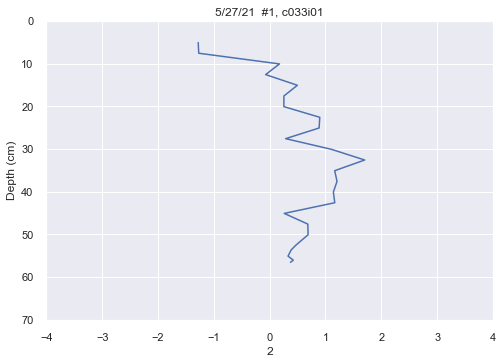

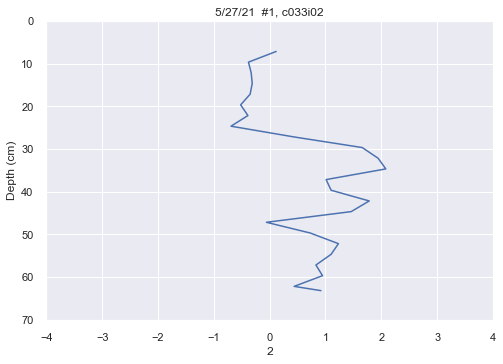

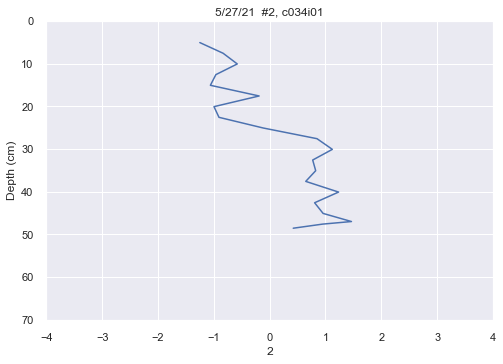

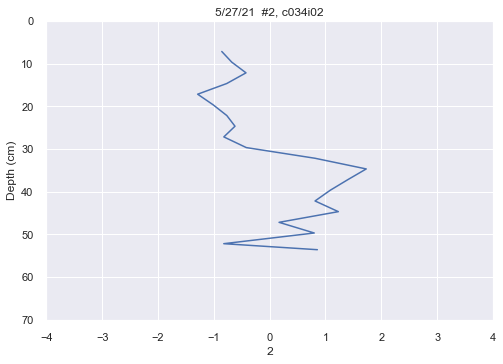

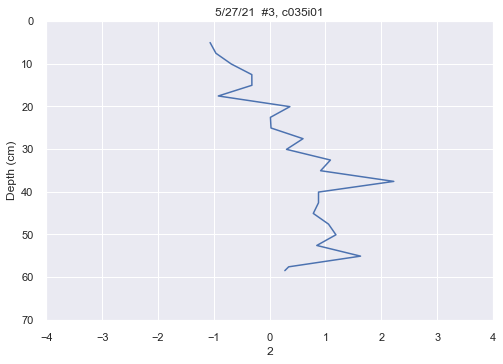

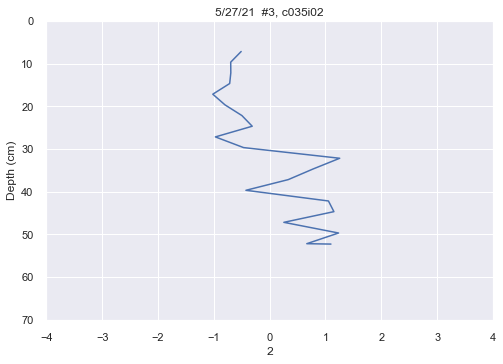

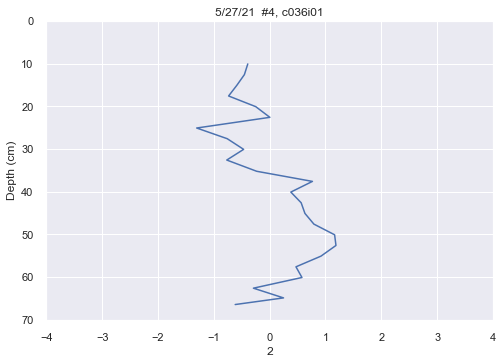

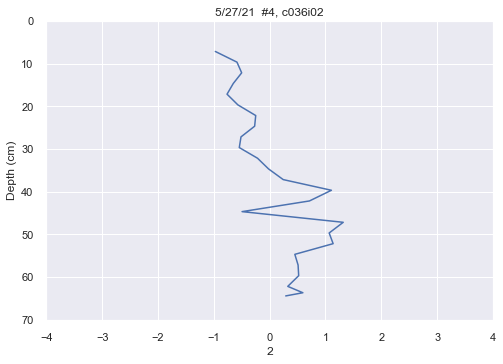

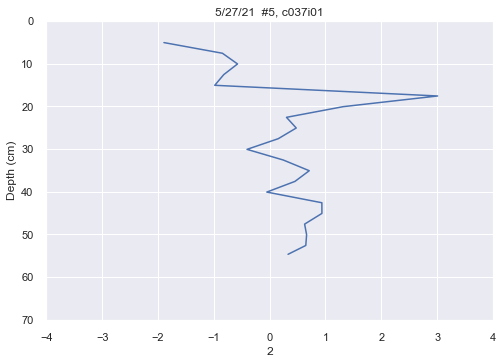

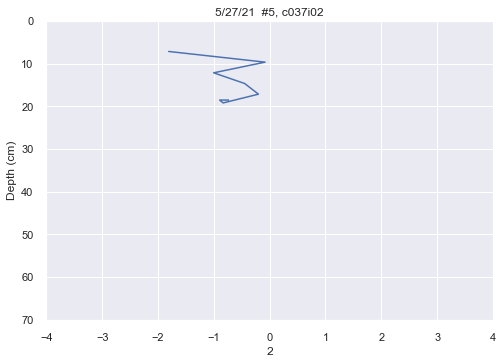

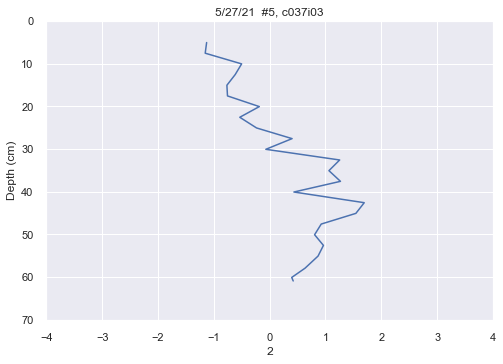

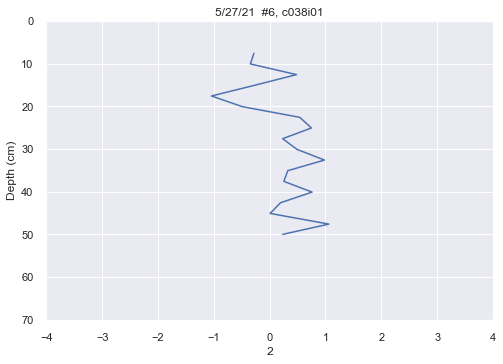

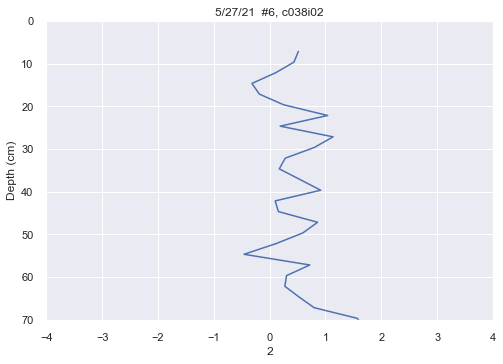

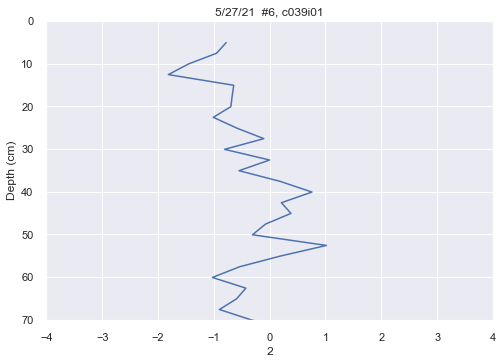

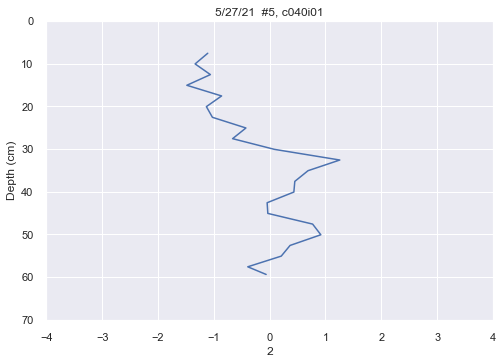

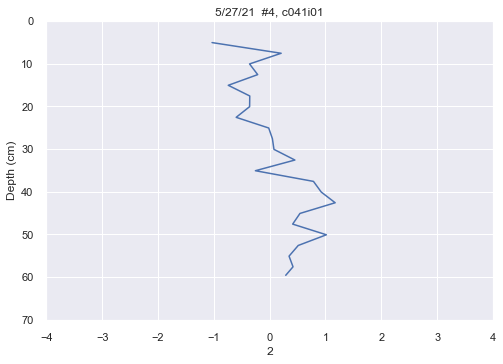

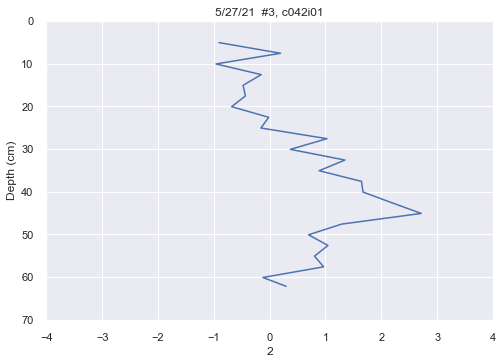

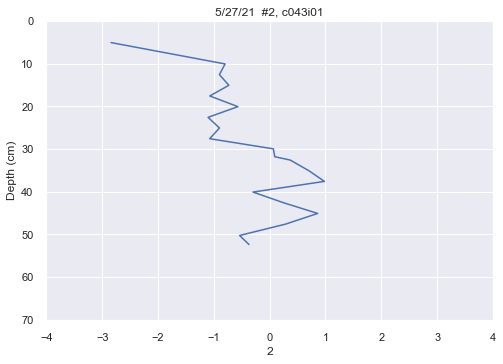

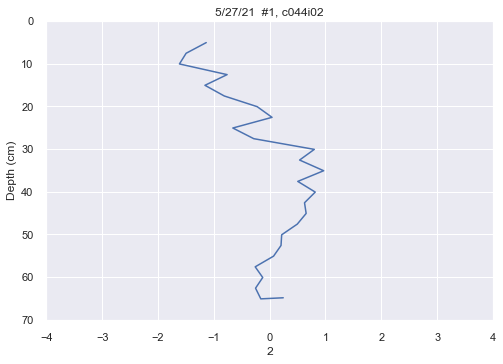

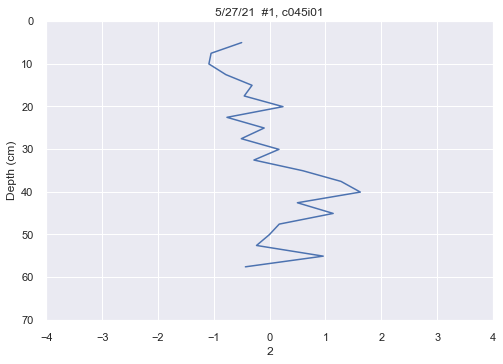

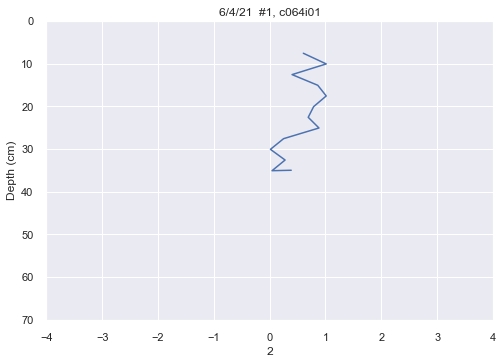

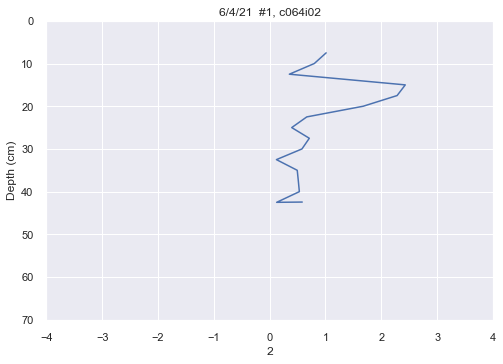

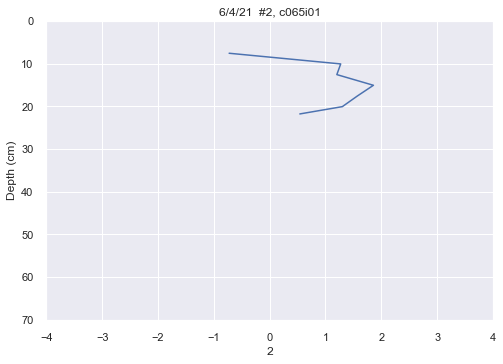

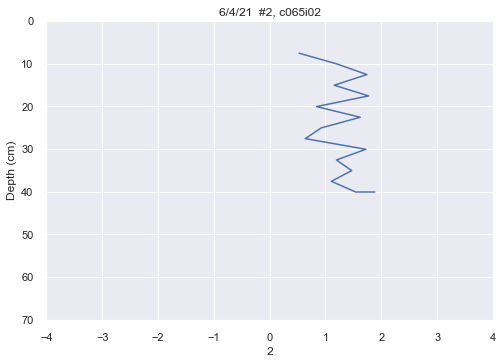

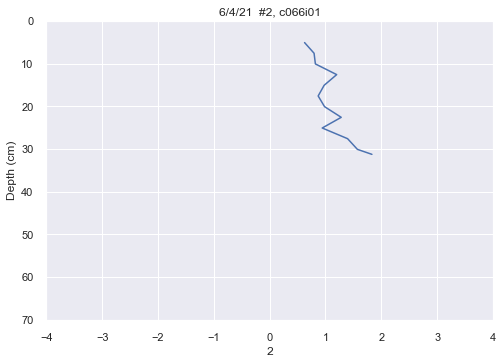

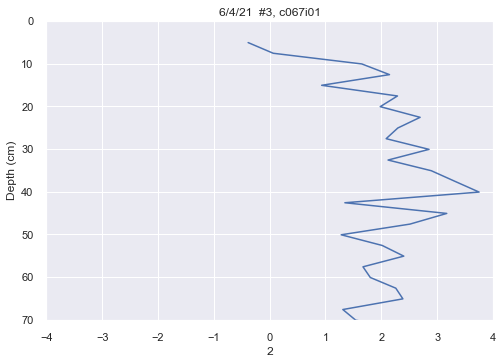

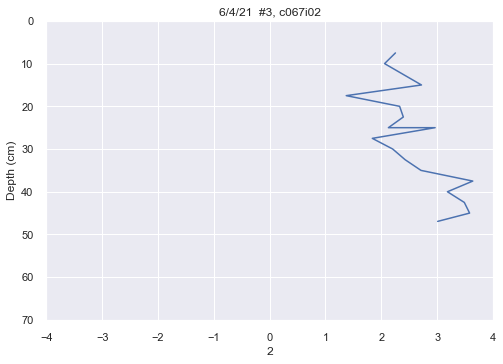

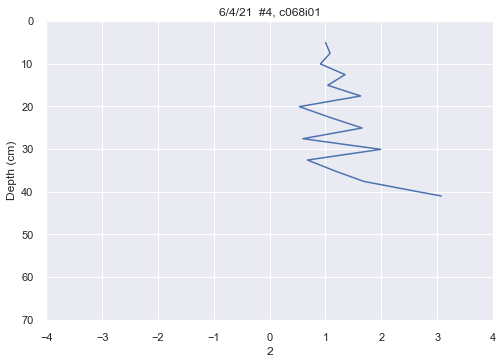

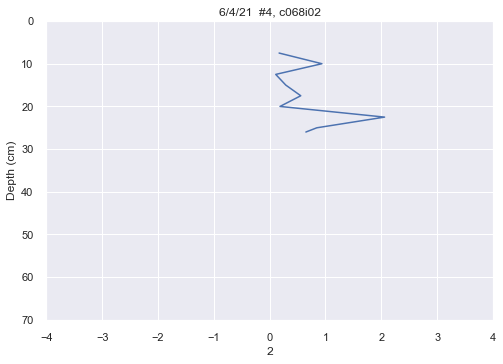

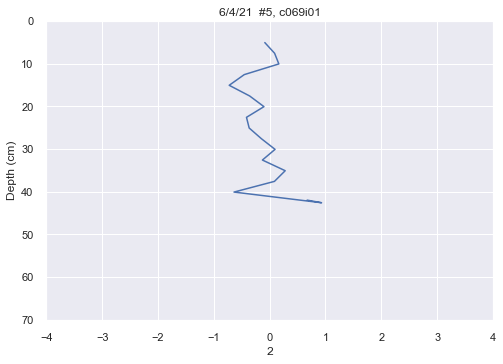

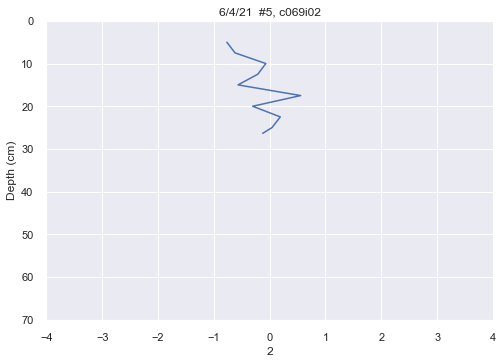

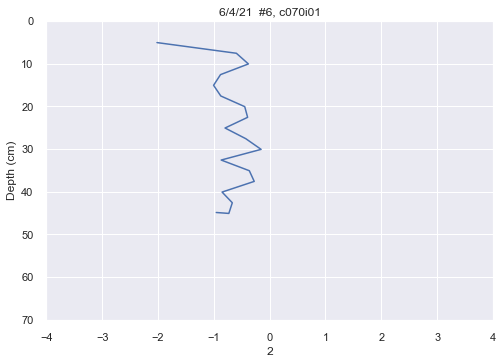

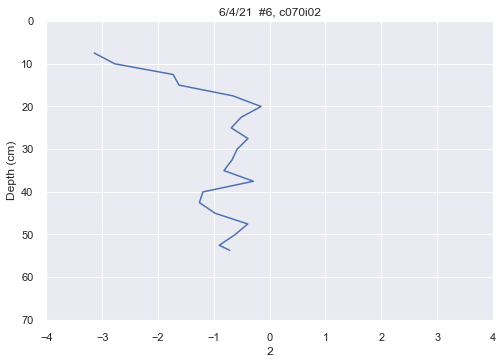

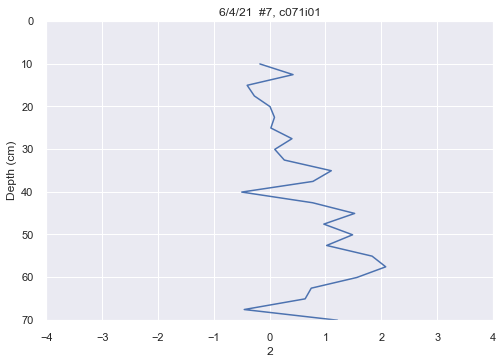

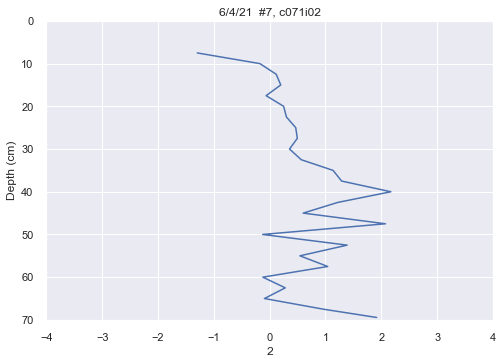

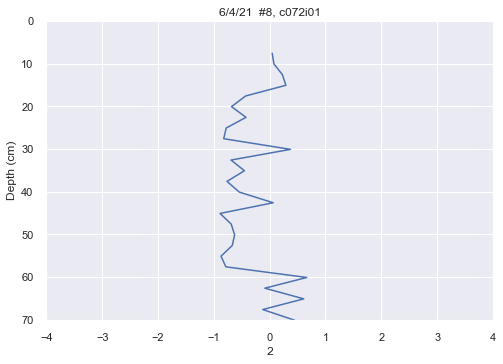

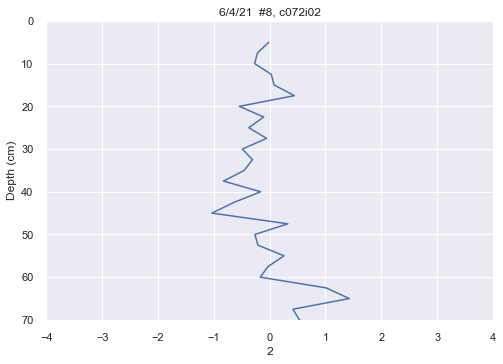

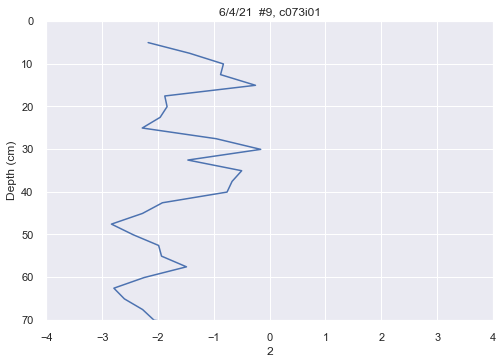

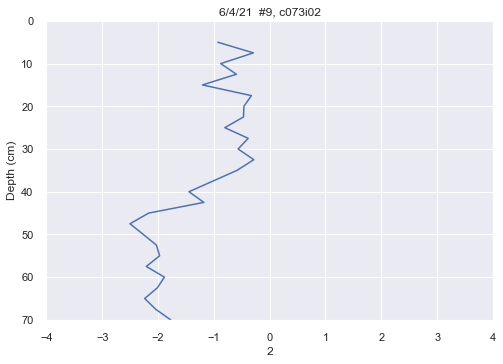

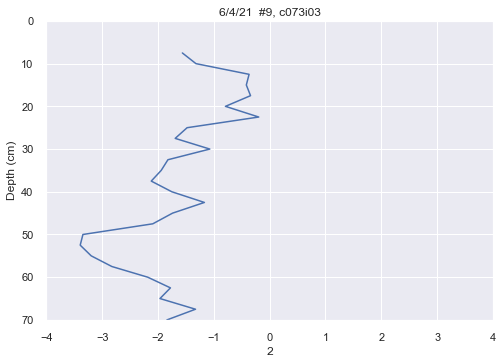

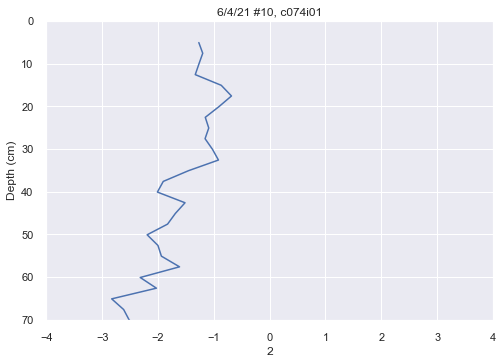

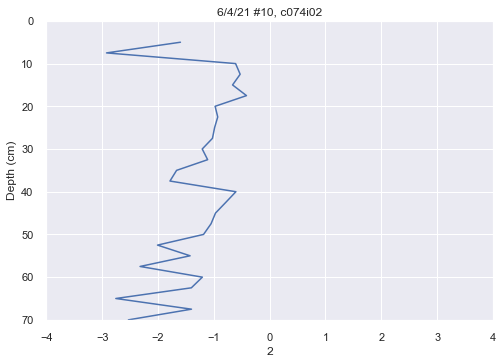

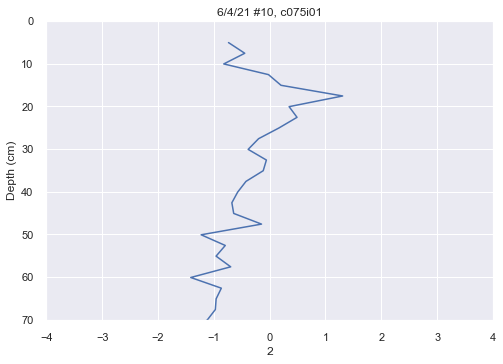

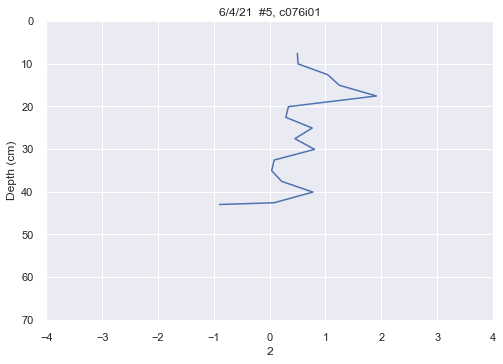

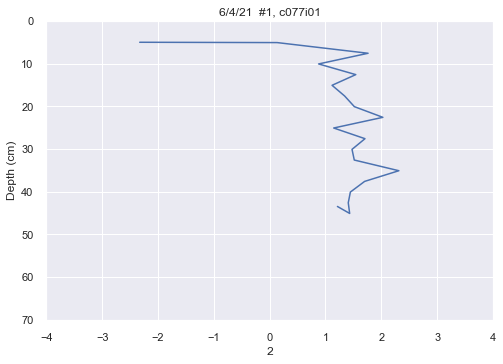

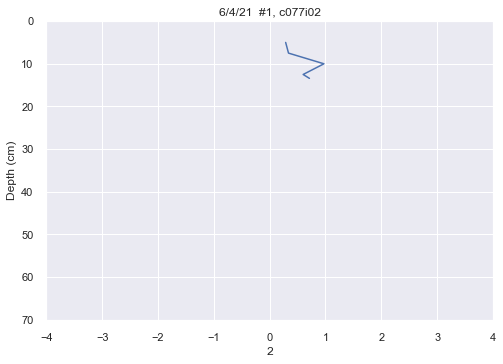

In [45]:
component = 2
for insertion in df_info['i_unique'].unique():
    insertion_df_info = df_info.loc[df_info['i_unique'] == insertion]
    insertion_components = X_pca_df.loc[df_info['i_unique'] == insertion]
    fig, ax = plt.subplots()
    ax.set_title(f"{insertion_df_info.iat[0, -3]}, {insertion}")
    ax.set_ylim(70, 0)
    ax.set_xlim(-4, 4)
    ax.set_ylabel("Depth (cm)")
    ax.set_xlabel(f"{component}")
    ax.plot(insertion_components.iloc[:, component], insertion_df_info['depth'])
    plt.show()
    plt.close()

# Check to see what mean absorbance tells us about these stops

Presumably higher SOC samples should have generally higher mean absorbance

In [46]:
mean_absorbance = df_use.groupby('stop').mean()

In [47]:
mean_mean_absorbance = mean_absorbance.iloc[:, :-3].mean(axis=1)

In [48]:
mean_mean_absorbance

stop
5/27/21  #1    0.549577
5/27/21  #2    0.516024
5/27/21  #3    0.543682
5/27/21  #4    0.569161
5/27/21  #5    0.590574
5/27/21  #6    0.637390
6/4/21  #1     0.572229
6/4/21  #2     0.612955
6/4/21  #3     0.727313
6/4/21  #4     0.584748
6/4/21  #5     0.580764
6/4/21  #6     0.520261
6/4/21  #7     0.551284
6/4/21  #8     0.619726
6/4/21  #9     0.654344
6/4/21 #10     0.674155
dtype: float64

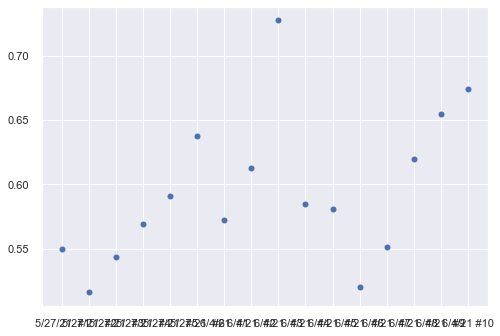

In [49]:
plt.plot(mean_mean_absorbance, 'o')

In [50]:
mean_X_pca = X_pca_df.groupby(df_info['stop']).mean()

### How does the pattern for mean absorance compare to the pattern for PC1?

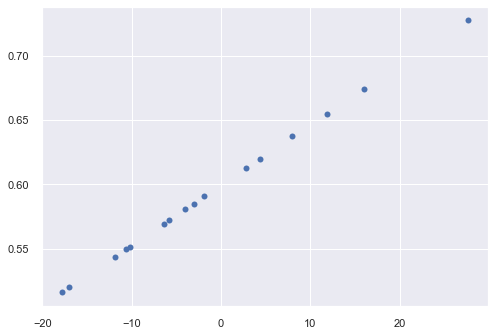

In [51]:
plt.plot(mean_X_pca['PC1'], mean_mean_absorbance, 'o' )

In [52]:
df_use.iloc[:, :-8]

533.4     534.8     536.2     537.7     539.1     540.5     541.9  \
2     0.550266  0.547796  0.563194  0.550510  0.549021  0.556036  0.533332   
3     0.553913  0.575164  0.567536  0.539224  0.559344  0.567863  0.563882   
4     0.686202  0.702606  0.670263  0.671369  0.690622  0.696210  0.682942   
5     0.631742  0.654073  0.648693  0.630098  0.616167  0.650735  0.620550   
6     0.721459  0.742745  0.703662  0.700518  0.717516  0.694641  0.685178   
...        ...       ...       ...       ...       ...       ...       ...   
1120  0.699840  0.709474  0.723073  0.728634  0.733417  0.723443  0.697404   
1121  0.722083  0.708788  0.722387  0.694436  0.731891  0.728441  0.699109   
1122  0.735795  0.730332  0.724677  0.724574  0.763250  0.722616  0.724108   
1123  0.727268  0.709932  0.730223  0.749050  0.769614  0.713820  0.718912   
1124  0.685619  0.639466  0.677712  0.640160  0.669927  0.676026  0.651521   

         543.4     544.8     546.2  ...     835.0     836.2     837.4  \
2     0.541878  0.533451  0.535555  ...  0.401945  0.409963  0.404762   
3     0.586287  0.554126  0.562368  ...  0.424523  0.416682  0.415174   
4     0.711097  0.694321  0.668574  ...  0.465726  0.458915  0.453241   
5     0.653872  0.624472  0.638912  ...  0.444502  0.434112  0.443892   
6     0.741355  0.697902  0.699171  ...  0.509457  0.512354  0.506424   
...        ...       ...       ...  ...       ...       ...       ...   
1120  0.691037  0.731349  0.713582  ...  0.483404  0.486455  0.489401   
1121  0.728214  0.703620  0.718620  ...  0.501169  0.499493  0.506607   
1122  0.729617  0.753423  0.721890  ...  0.496467  0.496569  0.491357   
1123  0.722648  0.695937  0.719707  ...  0.507279  0.507143  0.506970   
1124  0.645072  0.659597  0.660123  ...  0.473826  0.480114  0.477505   

         838.7     839.9     841.1     842.3     843.5     844.7     845.9  
2     0.403786  0.399996  0.403702  0.403303  0.402973  0.402337  0.409881  
3     0.412768  0.412454  0.414864  0.416569  0.407689  0.416483  0.399619  
4     0.447985  0.460501  0.452828  0.455022  0.461921  0.454554  0.458807  
5     0.444352  0.438087  0.442618  0.445295  0.438711  0.439980  0.450573  
6     0.499361  0.498442  0.498158  0.499910  0.502380  0.492444  0.496678  
...        ...       ...       ...       ...       ...       ...       ...  
1120  0.476159  0.475143  0.481971  0.479071  0.473218  0.471082  0.458113  
1121  0.489897  0.494935  0.494727  0.486645  0.475499  0.484531  0.490140  
1122  0.490322  0.494286  0.475696  0.485918  0.487966  0.491792  0.476648  
1123  0.497184  0.511758  0.507643  0.496432  0.500726  0.491565  0.513710  
1124  0.471313  0.478599  0.480058  0.468685  0.467639  0.463590  0.472702  

[1006 rows x 241 columns]

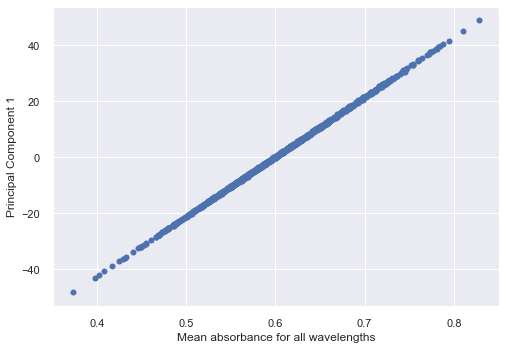

In [53]:
fig, ax = plt.subplots()
ax.set_xlabel("Mean absorbance for all wavelengths")
ax.set_ylabel("Principal Component 1")
plt.plot(df_use.iloc[:, :-8].mean(axis=1), X_pca_df['PC1'], 'o');